1


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 16.85it/s]


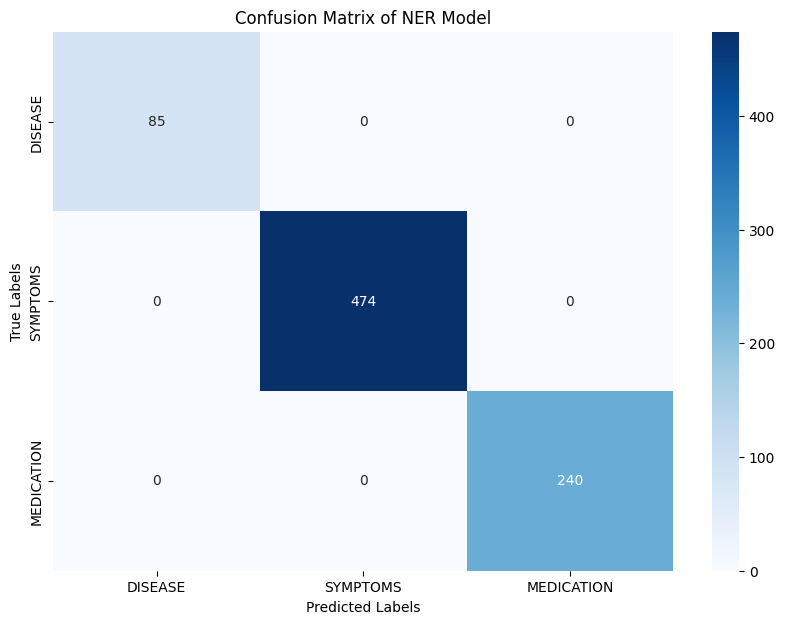

              precision    recall  f1-score   support

     DISEASE       1.00      1.00      1.00        85
    SYMPTOMS       0.99      1.00      1.00       474
  MEDICATION       1.00      1.00      1.00       240

   micro avg       1.00      1.00      1.00       799
   macro avg       1.00      1.00      1.00       799
weighted avg       1.00      1.00      1.00       799



In [5]:
# Import required libraries
import spacy
from spacy.tokens import DocBin
from tqdm import tqdm
import json
import fitz
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Load the annotated data from a JSON file
cv_data = json.load(open('training_data.json', 'r'))

# Display the number of items in the dataset
print(len(cv_data))

# Define a function to create spaCy DocBin objects from the annotated data
def get_spacy_doc(file, data):
    nlp = spacy.blank('en')
    db = DocBin()

    for text, annot in tqdm(data):
        doc = nlp.make_doc(text)
        annot = annot['entities']

        ents = []
        entity_indices = []

        for start, end, label in annot:
            skip_entity = False
            for idx in range(start, end):
                if idx in entity_indices:
                    skip_entity = True
                    break
            if skip_entity:
                continue

            entity_indices = entity_indices + list(range(start, end))
            try:
                span = doc.char_span(start, end, label=label, alignment_mode='strict')
            except:
                continue

            if span is None:
                err_data = str([start, end]) + "    " + str(text) + "\n"
                file.write(err_data)
            else:
                ents.append(span)

        try:
            doc.ents = ents
            db.add(doc)
        except:
            pass

    return db

# Split the annotated data into training and testing sets
annotations = cv_data['annotations']
train_ann, test_ann = train_test_split(annotations, test_size=0.2)

# Create spaCy DocBin objects for training and testing data
file = open('train_file.txt', 'w')
db = get_spacy_doc(file, train_ann)
db.to_disk('train_data.spacy')

db = get_spacy_doc(file, test_ann)
db.to_disk('test_data.spacy')
file.close()

# Load the trained spaCy NER model
nlp = spacy.load('D:/output/model-best')

# Extract true labels and predicted labels from the test set
true_labels = []
pred_labels = []
labels = set()

# Iterate through the test set
for text, annot in test_ann:
    doc = nlp(text)

    # Create a list to store the true and predicted entity tags for each token
    doc_true_labels = ['O'] * len(doc)
    doc_pred_labels = ['O'] * len(doc)

    # Annotate true entities in the tokenized doc
    for start, end, label in annot['entities']:
        span = doc.char_span(start, end, alignment_mode='strict')
        if span is not None:
            for token in span:
                doc_true_labels[token.i] = label
                labels.add(label)
    
    # Annotate predicted entities in the tokenized doc
    for ent in doc.ents:
        for token in ent:
            doc_pred_labels[token.i] = ent.label_
            labels.add(ent.label_)

    # Add the results for this document to the overall true and predicted lists
    true_labels.extend(doc_true_labels)
    pred_labels.extend(doc_pred_labels)

# Generate and display the confusion matrix
cm = confusion_matrix(true_labels, pred_labels, labels=list(labels))

# Plot the confusion matrix using seaborn
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix of NER Model')
plt.show()

# Optional: Print classification report
print(classification_report(true_labels, pred_labels, labels=list(labels)))
